# Урок 6. Нейросети в обработке текста

## Домашнее задание

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

Цель этой задачи — обнаружить язык ненависти в твитах. Для простоты мы говорим, что твит содержит разжигание ненависти, если с ним связаны расистские или сексистские настроения. Итак, задача состоит в том, чтобы отделить расистские или сексистские твиты от других твитов.

Формально, учитывая обучающую выборку твитов, где метка «1» означает, что твит является расистским/сексистским, а метка «0» означает, что твит не является расистским/сексистским, ваша цель состоит в том, чтобы предсказать метки в тестовом наборе данных.

### Подключение библиотек

In [67]:
! pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import re
from tqdm import tqdm 

import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings('ignore')

In [69]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [70]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и подготовка данных

In [72]:
# Загрузим тестовый и тренировочный датасеты с твитами
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
train_df.shape, test_df.shape

((31962, 3), (17197, 2))

In [73]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [74]:
test_df.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [75]:
# разделим данные на тренировочные и тестовые
X_train, X_valid = train_test_split(train_df, test_size=0.3, random_state=42)
X_train.shape, X_valid.shape

((22373, 3), (9589, 3))

In [76]:
# посмотрим распределение классов
X_train.label.value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [77]:
X_valid.label.value_counts()

0    8905
1     684
Name: label, dtype: int64

In [78]:
# список стоп-слов и знаков пунктуации
stop_words = set(get_stop_words('en'))
puncts = set(punctuation)

In [79]:
morpher = WordNetLemmatizer()
def preprocess_text(txt):
    txt = str(txt)
    # удаляем знаки препинания
    txt = ''.join(symbol for symbol in txt if symbol not in puncts)
    txt = txt.lower()
    # удаляем слова из стоп-листа
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in stop_words]
    return ' '.join(txt)

In [80]:
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_valid['tweet'] = X_valid['tweet'].progress_apply(preprocess_text)
test_df['tweet'] = test_df['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:00<00:00, 21538.06it/s]


In [81]:
# генерация токенов
tokens = word_tokenize(" ".join(X_train["tweet"]).lower())
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [82]:
# фильтр, чтобы оставить только цифры и слова
tokens_filtered = [word for word in tokens if word.isalnum()]
tokens_filtered[:10]

['summer',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'dese',
 'nigga']

In [83]:
# частота вхождения токенов
dist = FreqDist(tokens_filtered)

In [84]:
# топ частых слов
max_words = 2000
# 2000 самых частых
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'just', 'will', 'time', 'life'])

In [85]:
# словарь из частых слов и присвоение им индексов
vocabulary = {token: index for index, token in dict(enumerate(tokens_filtered_top, 1)).items()}
for token, idx in vocabulary.items():
    print(f'{token}: {idx}')
    if idx == 10:
        break

user: 1
love: 2
day: 3
happy: 4
u: 5
amp: 6
just: 7
will: 8
time: 9
life: 10


In [86]:
# преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  # токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] # фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) # если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) # нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [87]:
max_len = 20
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in X_valid['tweet']])
x_test = np.asarray([text_to_sequence(text, max_len) for text in test_df['tweet']])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [88]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() # преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  # индексация данных
        y = self.target[index]  # индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [89]:
train_dataset = DataWrapper(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

valid_dataset = DataWrapper(x_valid, X_valid.label.values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

## Построение и обучение модели

In [90]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [91]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [92]:
model = Net().to(device)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss() 

In [94]:
#обучение модели
model.train()
th = 0.5
epochs = 10

train_loss_history = []
valid_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1].to(device)
                test_outputs = model(data[0].to(device))
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/224]. Loss: 0.760. Acc: 0.090. Val loss: 0.734. Val acc: 0.071
Epoch [1/10]. Step [151/224]. Loss: 0.332. Acc: 0.909. Val loss: 0.075. Val acc: 0.929
Epoch [2/10]. Step [1/224]. Loss: 0.276. Acc: 0.920. Val loss: 0.066. Val acc: 0.929
Epoch [2/10]. Step [151/224]. Loss: 0.268. Acc: 0.929. Val loss: 0.069. Val acc: 0.929
Epoch [3/10]. Step [1/224]. Loss: 0.219. Acc: 0.940. Val loss: 0.065. Val acc: 0.929
Epoch [3/10]. Step [151/224]. Loss: 0.294. Acc: 0.930. Val loss: 0.410. Val acc: 0.929
Epoch [4/10]. Step [1/224]. Loss: 0.247. Acc: 0.910. Val loss: 0.146. Val acc: 0.929
Epoch [4/10]. Step [151/224]. Loss: 0.266. Acc: 0.934. Val loss: 0.525. Val acc: 0.934
Epoch [5/10]. Step [1/224]. Loss: 0.116. Acc: 0.980. Val loss: 0.401. Val acc: 0.937
Epoch [5/10]. Step [151/224]. Loss: 0.213. Acc: 0.944. Val loss: 0.560. Val acc: 0.939
Epoch [6/10]. Step [1/224]. Loss: 0.123. Acc: 0.940. Val loss: 0.047. Val acc: 0.941
Epoch [6/10]. Step [151/224]. Loss: 0.121. Acc: 0.952. 

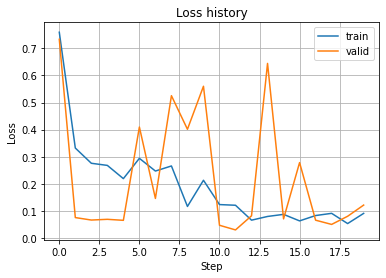

In [95]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

1. Число эпох в данной модели не сильно влияет на значения метрики. Метрики на валидации примерно одинаковые с первой эпохи.
2. Модель довольно простая. Можно менять различные её параметры, и это не сильно скажется на результатах её обучения.
3. На графике можно наблюдать, что лосс иногда подскакивает. Вероятно, это связано с дисбалансом классов.